In [13]:
import numpy as np
import sys
import pennylane as qml
from pygridsynth.gridsynth import gridsynth_gates

import warnings
from pennylane import PennyLaneDeprecationWarning

warnings.filterwarnings("ignore", category=PennyLaneDeprecationWarning)

sys.path.append('/global/homes/f/fkiwit/dev/data_compression/compression')

from utils.unitary_to_pennylane import UnitaryToPennylane

In [14]:
import numpy as np

def random_so2():
    """Sample a random 2x2 SO(2) matrix (rotation)."""
    theta = np.random.uniform(0, 2*np.pi)
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

def cnot_matrix():
    """Standard 4x4 CNOT gate (control = 0, target = 1)."""
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ])

def sample_gate():
    """Sample one 4x4 gate: kron(SO(2), SO(2)) @ CNOT"""
    U1 = random_so2()
    U2 = random_so2()
    kron_u = np.kron(U1, U2)
    return kron_u @ cnot_matrix()

def sample_staircase(depth=12, num_gates=2):
    """Sample a staircase of shape (depth, num_gates, 4, 4)."""
    circuit = []
    for _ in range(depth):
        layer = [sample_gate() for _ in range(num_gates)]
        circuit.append(np.stack(layer))  # shape (num_gates, 4, 4)
    return np.stack(circuit)  # shape (depth, num_gates, 4, 4)

# Example usage:
staircase_circuit = sample_staircase(depth=12, num_gates=2)
print(staircase_circuit.shape)  # (12, 2, 4, 4)


(12, 2, 4, 4)


In [ ]:
gate_map_penny = {
    # Clifford generators
    "H"  : lambda w: qml.Hadamard(wires=w),
    "X"  : lambda w: qml.PauliX(wires=w),
    "Y"  : lambda w: qml.PauliY(wires=w),
    "Z"  : lambda w: qml.PauliZ(wires=w),
    "S"  : lambda w: qml.S(wires=w),
    "Sdg": lambda w: qml.adjoint(qml.S)(wires=w),
    "S†" : lambda w: qml.adjoint(qml.S)(wires=w),
    "s"  : lambda w: qml.adjoint(qml.S)(wires=w),

    # T / T†
    "T"  : lambda w: qml.T(wires=w),
    "Tdg": lambda w: qml.adjoint(qml.T)(wires=w),
    "T†" : lambda w: qml.adjoint(qml.T)(wires=w),
    "t"  : lambda w: qml.adjoint(qml.T)(wires=w),
}

def _rz_word(theta):
    """Return the gate word generated by gridsynth for an RZ rotation."""
    word = gridsynth_gates(theta=theta, epsilon=EPS)
    return list(word) if isinstance(word, str) else word

def _word_to_ops(word, wire):
    """Convert a gridsynth word (as list) into PennyLane ops (reversed order)."""
    ops = []
    for tok in reversed(word):
        if tok in {"W", "Wdg", "W†", "w", "I"}:
            continue
        ops.append(gate_map_penny[tok](wire))
    return ops

def compile_rz(theta, wire):
    """Decompose RZ(theta) into Clifford+T on *wire*."""
    return _word_to_ops(_rz_word(theta), wire)

def compile_rx(theta, wire):
    """Decompose RX(theta) into Clifford+T on *wire* using H · RZ · H."""
    word = ["H"] + _rz_word(theta) + ["H"]
    return _word_to_ops(word, wire)

def compile_ry(theta, wire):
    """Decompose RY(theta) into Clifford+T on *wire* using S · H · RZ · H · S†."""
    word = ["S", "H"] + _rz_word(theta) + ["H", "Sdg"]
    return _word_to_ops(word, wire)

def get_compiled(sample, depth, RY):

    staircase_circuit = sample[f"staircase_circuit_{depth}"]
    print(staircase_circuit.shape)
    target_state = sample[f"frqi_target"]
    compressed_state = sample[f'state_{depth}']
    if RY == "sparse":
        first_gates = sample[f"first_gates_{depth}"]
        print(first_gates)
        unitary_to_pennylane = UnitaryToPennylane((first_gates, staircase_circuit))
    else:
        unitary_to_pennylane = UnitaryToPennylane(staircase_circuit)

    circuit, params = unitary_to_pennylane.get_circuit(RY=RY)
    _ = circuit(params)

    gate_sequence = circuit.tape.operations
    gate_sequence_compiled = []
    for gate in gate_sequence:
        wire = gate.wires[0]
        if isinstance(gate, qml.RX):
            gate_sequence_compiled.extend(compile_rx(float(gate.parameters[0]), wire))
        elif isinstance(gate, qml.RY):
            gate_sequence_compiled.extend(compile_ry(float(gate.parameters[0]), wire))
        elif isinstance(gate, qml.RZ):
            gate_sequence_compiled.extend(compile_rz(float(gate.parameters[0]), wire))
        else:
            gate_sequence_compiled.append(gate)

    unique_gates = set(op.name for op in gate_sequence)
    print(f"Unique gates in gate_sequence: {unique_gates}")

    ry_count = sum(1 for op in gate_sequence if op.name == "RY")
    print(f"Number of RY gates in gate_sequence: {ry_count}")

    cnot_count = sum(1 for op in gate_sequence if op.name == "CNOT")
    print(f"Number of CNOT gates in gate_sequence: {cnot_count}")

    unique_gates = set(op.name for op in gate_sequence_compiled)
    print(f"Unique gates in gate_sequence_compiled: {unique_gates}")

    @qml.qnode(dev)
    def circuit_applier(gates):
        for op in gates:
            qml.apply(op)
        return qml.state()

    state_compiled = circuit_applier(gate_sequence_compiled)

    infidelity_target = 1 - np.abs(np.vdot(state_compiled, target_state))**2
    infidelity_compressed = 1 - np.abs(np.vdot(state_compiled, compressed_state))**2
    infidelity_not_compiled = 1 - np.abs(np.vdot(compressed_state, target_state))**2

    t_count = sum(
        1
        for op in gate_sequence_compiled
        if op.name in {"T", "Tdg", "T†"}
    )

    return t_count, infidelity_target, infidelity_compressed, infidelity_not_compiled

data_loader ={
    f"mnist_sparse": "../data/mnist/sparse_8_20250715-060921/",
    f"mnist_orthorgonal": "../data/mnist/orthogonal_8_20250306-035734/",
    f"mnist_unitary": "../data/mnist/unitary_8_20250306-040348/",
    f"fashion_mnist_sparse": "../data/fashion_mnist/sparse_8_20250715-084149/",
    f"fashion_mnist_orthorgonal": "../data/fashion_mnist/orthogonal_8_20250306-051726/",
    f"fashion_mnist_unitary": "../data/fashion_mnist/unitary_8_20250306-052929/",
    f"cifar10_sparse": "../data/cifar10/sparse_8_20250715-125533/",
    f"cifar10_orthorgonal": "../data/cifar10/cnot_count/cifar10_orthogonal_8_20241217-014108/",
    f"cifar10_unitary": "../data/cifar10/cnot_count/cifar10_unitary_8_20241217-015052/",
    f"imagenette_sparse": "../data/imagenette_128/sparse_8_20250715-225556/",
    f"imagenette_orthorgonal": "../data/imagenette_128/_orthogonal_8_20250312-115249/",
    f"imagenette_unitary": "../data/imagenette_128/unitary_8_20250313-094859/"
}

EPS = 1e-5
DEPTH = 1
SAMPLE = 10

DATASET_TAG = "mnist"
# DATASET_TAG = "fashion_mnist"
# DATASET_TAG = "cifar10"
# DATASET_TAG = "imagenette"

CIRCUIT_TAG = "sparse"
# CIRCUIT_TAG = "orthorgonal"
# CIRCUIT_TAG = "unitary"

if DATASET_TAG == "cifar10":
    wires = 13
elif DATASET_TAG == "imagenette":
    wires = 17
else:
    wires = 11

dev = qml.device("default.qubit", wires=wires)

if CIRCUIT_TAG == "sparse":
    RY = "sparse"
elif CIRCUIT_TAG == "orthorgonal":
    RY = True
elif CIRCUIT_TAG == "unitary":
    RY = False

data = np.load(data_loader[f"{DATASET_TAG}_{CIRCUIT_TAG}"] + "compressed.npy", allow_pickle=True)
staircase_circuit = data[f"staircase_circuit_{DEPTH}"][SAMPLE]

sweep_state = np.array(data[f"state_{DEPTH}"][SAMPLE])

t_count, infidelity_target, infidelity_compressed, infidelity_not_compiled = get_compiled(data[0], DEPTH, RY)
print(f"T-count: {t_count}")
print(f"Infidelity target: {infidelity_target}")
print(f"Infidelity compressed: {infidelity_compressed}")
print(f"Infidelity not compiled: {infidelity_not_compiled}")


[[[[ 9.99813571e-01 -1.10263419e-02 -1.74796914e-04  1.58497105e-02]
   [-1.10263419e-02 -9.99813571e-01 -1.58497105e-02 -1.74796914e-04]
   [ 1.58497105e-02 -1.74796914e-04  1.10263419e-02 -9.99813571e-01]
   [-1.74796914e-04 -1.58497105e-02  9.99813571e-01  1.10263419e-02]]

  [[ 7.61544072e-01  6.29615432e-01  9.79596872e-02  1.18486008e-01]
   [ 6.29615432e-01 -7.61544072e-01 -1.18486008e-01  9.79596872e-02]
   [ 1.18486008e-01  9.79596872e-02 -6.29615432e-01 -7.61544072e-01]
   [ 9.79596872e-02 -1.18486008e-01  7.61544072e-01 -6.29615432e-01]]]


 [[[ 9.99979757e-01 -4.73744951e-03  2.01233423e-05 -4.24763049e-03]
   [-4.73744951e-03 -9.99979757e-01  4.24763049e-03  2.01233423e-05]
   [-4.24763049e-03  2.01233423e-05  4.73744951e-03 -9.99979757e-01]
   [ 2.01233423e-05  4.24763049e-03  9.99979757e-01  4.73744951e-03]]

  [[ 7.43252540e-01  6.63294665e-01 -5.81066384e-02 -6.51111924e-02]
   [ 6.63294665e-01 -7.43252540e-01  6.51111924e-02 -5.81066384e-02]
   [-6.51111924e-02 -5.810

In [10]:
import pandas as pd
import numpy as np
import warnings
from concurrent.futures import ProcessPoolExecutor

def safe_get_compiled(sample, depth, RY):
    # Turn that specific warning into an exception
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "error",
            message="invalid value encountered in arccos",
            category=RuntimeWarning
        )
        try:
            return get_compiled(sample, depth, RY)
        except RuntimeWarning:
            # Skip this sample
            return None

data = np.load(data_loader[f"{DATASET_TAG}_{CIRCUIT_TAG}"] + "compressed.npy", 
               allow_pickle=True)

summary_list = []

for depth in range(1, 8):
    print(f"⏳ Processing depth {depth}...")

    with ProcessPoolExecutor() as executor:
        # submit the “safe” version
        futures = [
            executor.submit(safe_get_compiled, sample, depth, RY) 
            for sample in data
        ]
        results = [f.result() for f in futures]

    # Filter out the None’s right away
    good_results = [r for r in results if r is not None]
    if not good_results:
        print(f"⚠️  All samples at depth {depth} failed!")
        continue

    df = pd.DataFrame(
        good_results,
        columns=[
            "t_count",
            "infidelity_target",
            "infidelity_compressed",
            "infidelity_not_compiled",
        ],
    )
    df["depth"] = depth

    # (No need to dropna if safe_get_compiled never returns partial data)
    # Compute summary statistics
    summary = {
        "depth": depth,
        "t_count_mean": df["t_count"].mean(),
        "infidelity_target_mean": df["infidelity_target"].mean(),
        "infidelity_target_25": df["infidelity_target"].quantile(0.25),
        "infidelity_target_75": df["infidelity_target"].quantile(0.75),
        "infidelity_compressed_mean": df["infidelity_compressed"].mean(),
        "infidelity_compressed_25": df["infidelity_compressed"].quantile(0.25),
        "infidelity_compressed_75": df["infidelity_compressed"].quantile(0.75),
        "infidelity_not_compiled_mean": df["infidelity_not_compiled"].mean(),
        "infidelity_not_compiled_25": df["infidelity_not_compiled"].quantile(0.25),
        "infidelity_not_compiled_75": df["infidelity_not_compiled"].quantile(0.75),
        "num_samples": len(df),
    }

    summary_list.append(summary)

summary_df = pd.DataFrame(summary_list)
print(summary_df)
summary_df.to_csv(
    data_loader[f"{DATASET_TAG}_{CIRCUIT_TAG}"] + "t_count.csv",
    index=False,
)


⏳ Processing depth 1...
Unique gates in gate_sequence: {'RY', 'CNOT'}
Unique gates in gate_sequence: {'RY', 'CNOT'}Number of RY gates in gate_sequence: 81

Number of CNOT gates in gate_sequence: 32Number of RY gates in gate_sequence: 81

Unique gates in gate_sequence_compiled: {'Hadamard', 'PauliX', 'CNOT', 'T', 'S', 'Adjoint(S)'}Number of CNOT gates in gate_sequence: 32

Unique gates in gate_sequence_compiled: {'Hadamard', 'PauliX', 'CNOT', 'T', 'S', 'Adjoint(S)'}
Unique gates in gate_sequence: {'RY', 'CNOT'}
Number of RY gates in gate_sequence: 81
Number of CNOT gates in gate_sequence: 32
Unique gates in gate_sequence_compiled: {'Hadamard', 'PauliX', 'CNOT', 'T', 'S', 'Adjoint(S)'}
Unique gates in gate_sequence: {'RY', 'CNOT'}
Number of RY gates in gate_sequence: 81
Number of CNOT gates in gate_sequence: 32
Unique gates in gate_sequence_compiled: {'Hadamard', 'PauliX', 'CNOT', 'T', 'S', 'Adjoint(S)'}
Unique gates in gate_sequence: {'RY', 'CNOT'}
Number of RY gates in gate_sequence: 8

MNIST $U(4)$: \alpha = 1.16 \pm 0.16 \beta = -1.03 \pm 0.017 
MNIST $U(4)$: \alpha = 1.75 \pm 0.08 \beta = -0.99 \pm 0.005 
MNIST $U(4)$: \alpha = 1.60 \pm 0.07 \beta = -1.00 \pm 0.005 
Fashion-MNIST $U(4)$: \alpha = 1.68 \pm 0.17 \beta = -0.99 \pm 0.013 
Fashion-MNIST $U(4)$: \alpha = 2.22 \pm 0.19 \beta = -0.96 \pm 0.010 
Fashion-MNIST $U(4)$: \alpha = 1.44 \pm 0.14 \beta = -1.01 \pm 0.011 
CIFAR-10 $U(4)$: \alpha = 3.51 \pm 0.31 \beta = -0.90 \pm 0.011 
CIFAR-10 $U(4)$: \alpha = 1.95 \pm 0.36 \beta = -0.97 \pm 0.021 
CIFAR-10 $U(4)$: \alpha = 1.33 \pm 0.22 \beta = -1.02 \pm 0.018 
Imagenette $U(4)$: \alpha = 3.09 \pm 0.85 \beta = -0.92 \pm 0.036 
Imagenette $U(4)$: \alpha = 2.00 \pm 0.68 \beta = -0.97 \pm 0.038 
Imagenette $U(4)$: \alpha = 1.70 \pm 0.12 \beta = -0.99 \pm 0.007 


/tmp/ipykernel_1752381/3123041784.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)    # hide legend duplicates
/tmp/ipykernel_1752381/3123041784.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)    # hide legend duplicates
/tmp/ipykernel_1752381/3123041784.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)    # hide legend duplicates
/tmp/ipykernel_1752381/3123041784.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() i

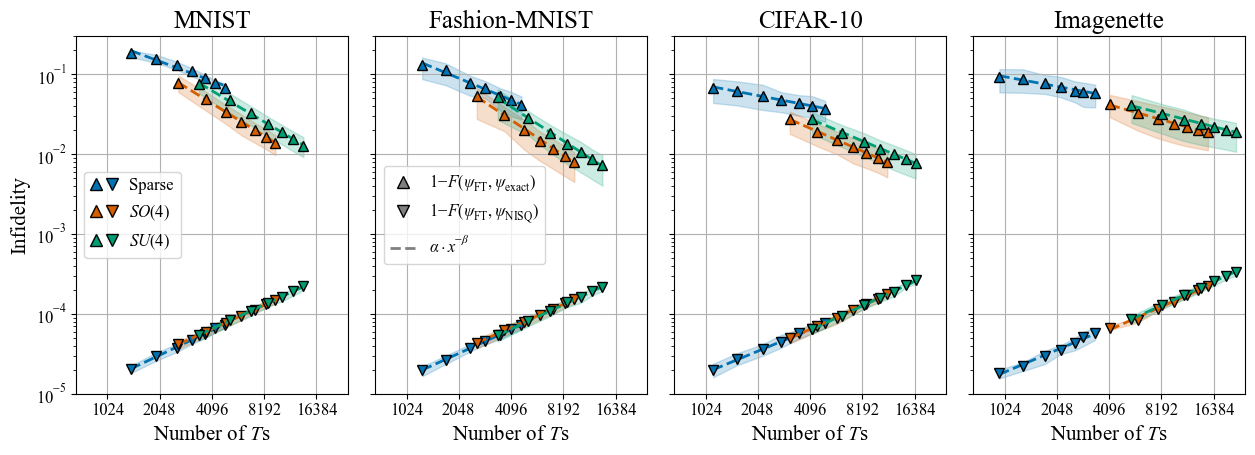

In [13]:
import matplotlib.pyplot as plt
from stylesheet import *
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# ------------------------------------------------------------------
# helper -----------------------------------------------------------
# ------------------------------------------------------------------
def add_subplot(ax, csv_path, dataset_name,
                face_marker, face_color,
                edge_marker=marker["triangle"], edge_color=color_palette["blue"], label=False):
    """Read one CSV, do the power-law fit, and draw the panel on *ax*."""
    # --- ingest & unpack -----------------------------------------------------
    df = pd.read_csv(csv_path)


    if face_marker == "o":
        mode = "Sparse"
    elif face_marker == "s":
        mode = "$SO(4)$"
    elif face_marker == "^":
        mode = "$U(4)$"
    else:
        mode = False

    x      = df["t_count_mean"].values
    y_targ = df["infidelity_target_mean"].values
    y_cmp  = df["infidelity_compressed_mean"].values

    # --- power-law fit (target & compressed) ---------------------------------
    log_x = np.log(x)

    p_targ, cov_targ = np.polyfit(log_x, np.log(y_targ), 1, cov=True)
    β_targ, lnα_targ = p_targ
    α_targ           = np.exp(lnα_targ)
    fit_targ         = α_targ * x ** β_targ

    # if mode:
    #     print(f"{dataset_name} {mode}: \\alpha = {α_targ:.3f} \\pm {α_targ * np.sqrt(cov_targ[1, 1]):.3f}, \\beta = {-β_targ:.3f} \\pm {np.sqrt(cov_targ[0, 0]):.3f}")

    p_cmp,  cov_cmp  = np.polyfit(log_x, np.log(y_cmp), 1, cov=True)
    β_cmp, lnα_cmp   = p_cmp
    α_cmp            = np.exp(lnα_cmp)
    fit_cmp          = α_cmp * x ** β_cmp
    if mode:
        print(f"{dataset_name} {mode}: \\alpha = {(α_cmp*10**8):.2f} \pm {α_cmp * np.sqrt(cov_cmp[1, 1])*10**8:.2f} \\beta = {-β_cmp:.2f} \\pm {np.sqrt(cov_cmp[0, 0]):.3f} ")

    # --- spread (25-/75-percentile) ------------------------------------------
    y_targ_p25 = df["infidelity_target_75"].values
    y_targ_p75 = df["infidelity_target_25"].values
    y_cmp_p25  = df["infidelity_compressed_75"].values
    y_cmp_p75  = df["infidelity_compressed_25"].values

    # --- plotting ------------------------------------------------------------
    ax.plot(x, fit_targ, linestyle='--', color=face_color, linewidth=line_width)
    ax.plot(x, fit_cmp,  linestyle='--', color=face_color, linewidth=line_width)

    ax.plot(x, y_targ, marker=face_marker, label=r'$1\!-\!F(\psi_{\mathrm{FT}},\psi_{\mathrm{exact}})$' if label else None,
            color=face_color, markersize=7, markeredgecolor="black",
            markeredgewidth=markeredgewidth, linestyle='')
    ax.plot(x, y_cmp,  marker=marker["triangle_down"], label=r'$1\!-\!F(\psi_{\mathrm{FT}},\psi_{\mathrm{NISQ}})$' if label else None,
            color=face_color, markersize=7, markeredgecolor="black",
            markeredgewidth=markeredgewidth, linestyle='')

    ax.fill_between(x, y_targ_p25, y_targ_p75, color=face_color, alpha=0.2)
    ax.fill_between(x, y_cmp_p25,  y_cmp_p75,  color=face_color, alpha=0.2)

    ax.plot([], [], color='gray', linestyle='--', linewidth=line_width)

    # --- cosmetics -----------------------------------------------------------
    ax.set_title(dataset_name)
    ax.set_xlabel(r'Number of $T$s')
    ax.grid(True)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    ax.set_xticks([1024, 2048, 4096, 8192, 16384])
    ax.set_xticklabels(['1024' ,'2048', '4096', '8192', '16384'])

    padding_factor = 0.15
    log_lower_x = np.log2(1024)
    log_upper_x = np.log2(16384)
    delta = log_upper_x - log_lower_x

    ax.set_xlim(2 ** (log_lower_x - padding_factor * delta),
                2 ** (log_upper_x + padding_factor * delta))

    ax.set_ylim([1e-5, 3e-1])

    # only the very first panel carries y-axis & legend
    if dataset_name == "MNIST" and label:
        ax.set_ylabel('Infidelity')
        # ax.legend()
    else:
        ax.set_yticklabels([])            # hide y-labels
        ax.legend().set_visible(False)    # hide legend duplicates

# ------------------------------------------------------------------
# figure -----------------------------------------------------------
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, 4, figsize=(12.8, 4.8))

# MNIST  →  axs[0]
add_subplot(
    ax            = axs[0],
    csv_path      = "../data/mnist/sparse_8_20250715-060921/t_count.csv",
    dataset_name  = "MNIST",
    face_marker   = marker["triangle"],
    face_color    = color_palette["blue"]
)

add_subplot(
    ax            = axs[0],
    csv_path      = "../data/mnist/orthogonal_8_20250306-035734/t_count.csv",
    dataset_name  = "MNIST",
    face_marker   = marker["triangle"],
    face_color    = color_palette["red"]
)

add_subplot(
    ax            = axs[0],
    csv_path      = "../data/mnist/unitary_8_20250306-040348/t_count.csv",
    dataset_name  = "MNIST",
    face_marker   = marker["triangle"],
    face_color    = color_palette["green"],
    label=True
)

# Fashion-MNIST  →  axs[1]
add_subplot(
    ax            = axs[1],
    csv_path      = "../data/fashion_mnist/sparse_8_20250715-084149/t_count.csv",
    dataset_name  = "Fashion-MNIST",
    face_marker   = marker["triangle"],
    face_color    = color_palette["blue"]
)

add_subplot(
    ax            = axs[1],
    csv_path      = "../data/fashion_mnist/orthogonal_8_20250306-051726/t_count.csv",
    dataset_name  = "Fashion-MNIST",
    face_marker   = marker["triangle"],
    face_color    = color_palette["red"],
)

add_subplot(
    ax            = axs[1],
    csv_path      = "../data/fashion_mnist/unitary_8_20250306-052929/t_count.csv",
    dataset_name  = "Fashion-MNIST",
    face_marker   = marker["triangle"],
    face_color    = color_palette["green"],
    label=True
)

# CIFAR-10  →  axs[2]
add_subplot(
    ax            = axs[2],
    csv_path      = "../data/cifar10/sparse_8_20250715-125533/t_count.csv",
    dataset_name  = "CIFAR-10",
    face_marker   = marker["triangle"],
    face_color    = color_palette["blue"],
)
add_subplot(
    ax            = axs[2],
    csv_path      = "../data/cifar10/cnot_count/cifar10_orthogonal_8_20241217-014108/t_count.csv",
    dataset_name  = "CIFAR-10",
    face_marker   = marker["triangle"],
    face_color    = color_palette["red"],
)
add_subplot(
    ax            = axs[2],
    csv_path      = "../data/cifar10/cnot_count/cifar10_unitary_8_20241217-015052/t_count.csv",
    dataset_name  = "CIFAR-10",
    face_marker   = marker["triangle"],
    face_color    = color_palette["green"],
)

# Imagenette  →  axs[3]
add_subplot(
    ax            = axs[3],
    csv_path      = "../data/imagenette_128/sparse_8_20250715-225556/t_count.csv",
    dataset_name  = "Imagenette",
    face_marker   = marker["triangle"],
    face_color    = color_palette["blue"],
)

add_subplot(
    ax            = axs[3],
    csv_path      = "../data/imagenette_128/_orthogonal_8_20250312-115249/t_count.csv",
    dataset_name  = "Imagenette",
    face_marker   = marker["triangle"],
    face_color    = color_palette["red"],
)

add_subplot(
    ax            = axs[3],
    csv_path      = "../data/imagenette_128/unitary_8_20250313-094859/t_count.csv",
    dataset_name  = "Imagenette",
    face_marker   = marker["triangle"],
    face_color    = color_palette["green"],
)

# define your custom legend entries:
# handles = [
#     Line2D([0], [0], linestyle='', marker='o',
#            markerfacecolor=color_palette["blue"], markeredgecolor="black",
#            markersize=7,),
#     Line2D([0], [0], linestyle='', marker='s',
#            markerfacecolor=color_palette["red"], markeredgecolor="black",
#            markersize=7,),
#     Line2D([0], [0], linestyle='', marker='^',
#            markerfacecolor=color_palette["green"], markeredgecolor="black",
#            markersize=7,),
#     Line2D([0], [0], linestyle='--', color='gray',
#            linewidth=line_width,),
# ]

# legend_labels = [
#     'Sparse',
#     '$SO(4)$',
#     '$SU(4)$',
#     r'$\alpha \cdot x^{-\beta}$',
# ]
# # add to your axis:
# axs[0].legend(handles, legend_labels,
#               loc='center left', handlelength=handlelength)

handles_0 = [
    # MPO (grouped tuple: 'P' and 'X' markers)

    (plt.Line2D([0], [0],
                color=color_palette["blue"], marker=marker["triangle"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'),
     plt.Line2D([0], [0],
                color=color_palette["blue"], marker=marker["triangle_down"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black')),
    
    # MPS (grouped tuple: '<' and '>' markers)
    (plt.Line2D([0], [0],
                color=color_palette["red"], marker=marker["triangle"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'),
     plt.Line2D([0], [0],
                color=color_palette["red"], marker=marker["triangle_down"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black')),
    
    # MPS (grouped tuple: '<' and '>' markers)
    (plt.Line2D([0], [0],
                color=color_palette["green"], marker=marker["triangle"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'),
     plt.Line2D([0], [0],
                color=color_palette["green"], marker=marker["triangle_down"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'))]

handles_1 = [
     plt.Line2D([0], [0],
                color="gray", marker=marker["triangle"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'),
     plt.Line2D([0], [0],
                color="gray", marker=marker["triangle_down"], linestyle='',
                markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'),

    # Random init. (single line)
    plt.Line2D([0], [0],
               color="gray", linestyle='--', linewidth=line_width),

]

# Matching labels for each handle
# labels = ['MPO', 'MPS', 'Warmstart', 'SVM']

labels_0 = [
    'Sparse',
    '$SO(4)$',
    '$SU(4)$',
]

labels_1 = [
    r'$1\!-\!F(\psi_{\mathrm{FT}},\psi_{\mathrm{exact}})$',
    r'$1\!-\!F(\psi_{\mathrm{FT}},\psi_{\mathrm{NISQ}})$',
    r'$\alpha \cdot x^{-\beta}$',
]

# Use handler_map to tell Matplotlib that tuples should be handled by HandlerTuple
axs[0].legend(handles=handles_0, labels=labels_0, loc='center left',
                 handlelength=1.5,
                 handler_map={tuple: HandlerTuple(ndivide=None)})

# Use handler_map to tell Matplotlib that tuples should be handled by HandlerTuple
axs[1].legend(handles=handles_1, labels=labels_1, loc='center left',
                 handlelength=1.5,
                 handler_map={tuple: HandlerTuple(ndivide=None)})

# (Optionally leave axs[3] empty or reuse it.)
plt.tight_layout()
plt.savefig('encoding_t_infid.pdf')
plt.show()